# When To Invest?

I was wondering how import is timing when making an investment particularly if you have a longer holding period.

We are going to use the data from the the Federal Reserve Bank of St. Louis website more commonly known as FRED. There is a handy function available in the pandas module that will allow us to get the data directly and put it into a DataFrame.

In [1]:
%matplotlib inline

import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

In [2]:
import datetime as dt
import json
import os
import urllib.request
import pandas as pd
import sp500


def get_fed(data_id: str, start_date: str=None, end_date: str=None) -> pd.DataFrame:
    """
    get_fed can be a model for other json requests. The req string can be built
    to suit other api purposes. The creation of the DataFrame may require only a 
    change in the name of the column from observations to something appropriate
    
    Parameters
    ----------
    data_id: str
        The name of the data item from the FRED. Example SP500 for the S&P 500.
    start_date: str
        Data start date in the format of %Y-%m-%d, e.g. 2015-12-31. The default
        start date is 10 years prior to the current day.
    end_date: str
        Data end date in the format of %Y-%m-%d, e.g. 2015-12-31. The default
        end date is today.
        
    Returns
    -------
    df: pandas DataFrame
    """
    filename = data_id + '.csv'
    if start_date is None:
        start_date = (dt.datetime.today() - dt.timedelta(days=3650)).strftime('%Y-%m-%d')
    if end_date is None:
        end_date = dt.datetime.today().strftime('%Y-%m-%d')
    if not os.path.exists(filename) or stale_file(filename, 7):
        ACCESS_KEY = sp500.fred_api
        req = urllib.request.urlopen('https://api.stlouisfed.org/fred/series/observations'
                                     + '?series_id=' + data_id
                                     + '&observation_start=' + start_date
                                     + '&observation_end=' + end_date
                                     + '&api_key=' + ACCESS_KEY
                                     + '&file_type=json').read().decode('utf-8')
        df = pd.DataFrame(json.loads(req)['observations'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')  # 'value' is an object
        df = df.set_index(pd.to_datetime(df['date']))
        df.rename(columns={'value' : data_id}, inplace=True)
        df.to_csv(data_id + '.csv')
        return df[[data_id]]
    else:
        return(pd.read_csv(data_id+'.csv', index_col=0, parse_dates=True))
    

def stale_file(filename: str, age_limit: int) -> bool:
    """
    Checks to see if a file is stale
    
    Parameters
    ----------
    filename: str
    age_limit: int
        The maximum age in days before a file is considered stale
    
    Returns
    -------
    True if the file is stale or False if it isn't
    """
    m_date = dt.datetime.fromtimestamp(os.stat('SP500.csv')
                                       .st_mtime).strftime('%Y%m%d')
    today = dt.datetime.today().strftime('%Y%m%d')
    if (dt.datetime.today() 
        - dt.datetime.fromtimestamp(os.stat(filename).st_mtime)).days > age_limit:
        return True

In [3]:
data_id, start_date = 'SP500', '1999-12-31'
df = get_fed(data_id, start_date)
df.head()

,SP500
date,
2008-09-02,1277.58
2008-09-03,1274.98
2008-09-04,1236.83
2008-09-05,1242.31
2008-09-08,1267.79


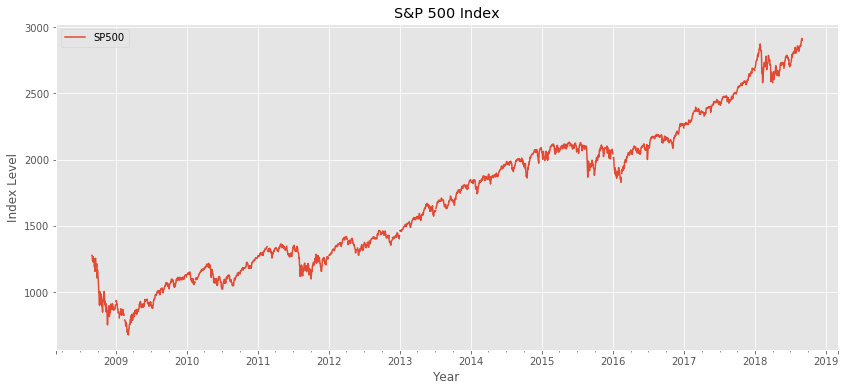

In [4]:
df[['SP500']].plot(figsize=(14,6))
plt.title('S&P 500 Index')
plt.ylabel('Index Level')
plt.xlabel('Year');

We have 10 years of daily data. Now we want to get the month end index levels and from those we will calculate calendar monthly returns.

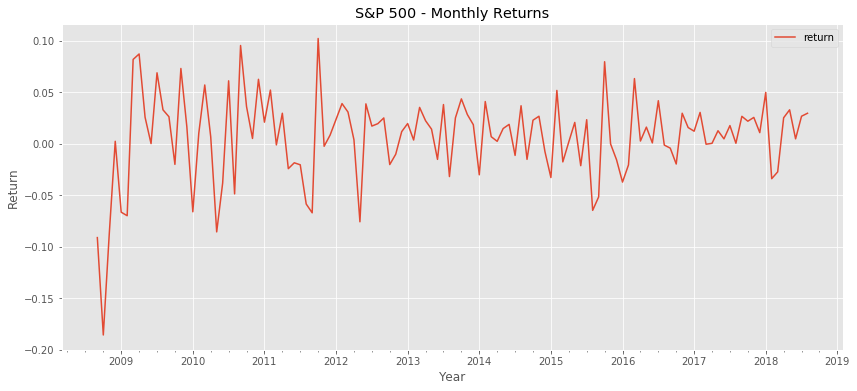

In [5]:
df['return'] = np.log(df[data_id]) - np.log(df[data_id].shift(1))
monthly = df[['return']].resample('M').sum()
monthly.plot(figsize=(14,6))
plt.title('S&P 500 - Monthly Returns')
plt.ylabel('Return')
plt.xlabel('Year');

## Rolling 1 Year Return or When Should I Buy?

This seems to imply that most of the time you can buy the S&P 500 and in a year, you will still have a postive return. We can calculate the proportion of positive 1 year holding periods to negative 1 year holding periods.

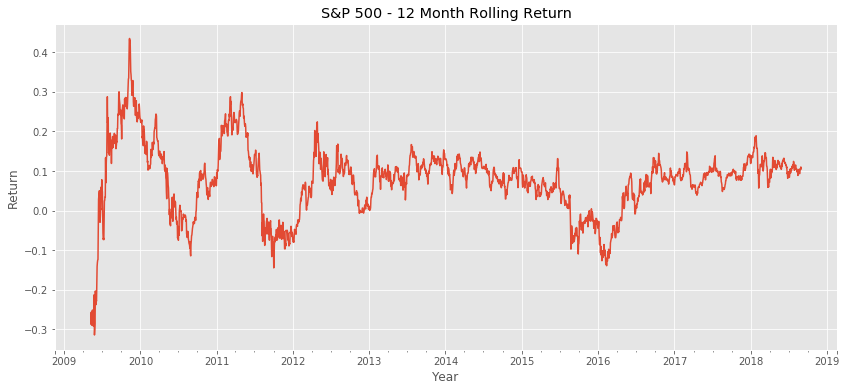

In [6]:
df['1 yr return'] = df['return'].resample('D').sum().rolling(250).sum()
df['1 yr return'].plot(figsize=(14,6))
plt.title('S&P 500 - 12 Month Rolling Return')
plt.ylabel('Return')
plt.xlabel('Year');

In [7]:
for ret in range(12):
    print('Exp return: {:0.1%} Probability: {:0.2%}'.format(ret/100, len(df[df['1 yr return'] > ret/100]) /
          (len(df[df['1 yr return'] > ret/100]) + len(df[df['1 yr return'] < ret/100]))))

Exp return: 0.0% Probability: 82.21%
Exp return: 1.0% Probability: 80.53%
Exp return: 2.0% Probability: 79.25%
Exp return: 3.0% Probability: 77.56%
Exp return: 4.0% Probability: 75.13%
Exp return: 5.0% Probability: 71.59%
Exp return: 6.0% Probability: 67.35%
Exp return: 7.0% Probability: 61.59%
Exp return: 8.0% Probability: 54.67%
Exp return: 9.0% Probability: 46.73%
Exp return: 10.0% Probability: 38.25%
Exp return: 11.0% Probability: 29.64%


# Calendar Study

## Months
Are there any patterns to the monthly returns? Does earnings season have an impact? Does the year end have an impact? Is there window dressing and tax loss effects? By studying the month-end returns we hope to answer these questions and uncover any other patterns.

Using the pivot_table command we change our monthly table that had each month and year represented in a row into one that has each month represented by row and each year represented by a column. The values in the table correspond to the monthly return.

In [8]:
pivoted = monthly.pivot_table('return', index=monthly.index.month, columns=monthly.index.year)
pivoted

date,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
date,,,,,,,,,,,
1,NaN,-0.066407,-0.066013,0.021018,0.023758,0.019693,-0.030100,-0.032742,-0.037177,0.012247,0.049919
2,NaN,-0.069827,0.010274,0.052199,0.039068,0.003690,0.041056,0.051843,-0.020519,0.030493,-0.033868
3,NaN,0.081953,0.057133,-0.001048,0.030852,0.035355,0.006908,-0.017549,0.063360,-0.000389,-0.027253
4,NaN,0.087242,0.006755,0.029691,0.003898,0.022408,0.002414,0.001898,0.002696,0.000474,0.025306
5,NaN,0.025758,-0.085532,-0.024130,-0.075717,0.014229,0.014842,0.020772,0.016214,0.012715,0.033010
6,NaN,0.000196,-0.038074,-0.018426,0.038793,-0.015113,0.018879,-0.021236,0.000906,0.004802,0.004831
7,NaN,0.068960,0.061171,-0.020371,0.017217,0.038128,-0.011263,0.023419,0.041862,0.017712,0.026804
8,NaN,0.033009,-0.048612,-0.058467,0.019571,-0.031798,0.036964,-0.064625,-0.001220,0.000546,0.029680
9,-0.091080,0.026294,0.095466,-0.067003,0.025114,0.025160,-0.015091,-0.051572,-0.004212,0.026698,NaN


In the chart below, each line represents a year and the months are represented by the x-axis.

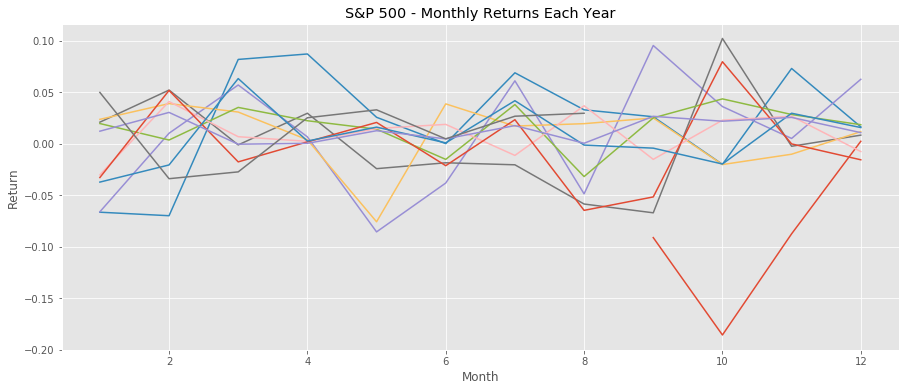

In [9]:
pivoted.plot(legend=False, figsize=(15,6))
plt.title('S&P 500 - Monthly Returns Each Year')
plt.ylabel('Return')
plt.xlabel('Month');

Using the describe() function we can calculate summary statistics for each month.

In [10]:
by_month = pivoted.transpose().describe()
by_month.rename(columns={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                         6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
                         11: 'Nov', 12: 'Dec'}, inplace=True)
by_month

date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.010580,0.010441,0.022932,0.018278,-0.004784,-0.002444,0.026364,-0.008495,-0.003023,0.006137,0.008897,0.012400
std,0.040885,0.040861,0.036572,0.026608,0.042732,0.021902,0.028229,0.039397,0.055157,0.079103,0.041366,0.020770
min,-0.066407,-0.069827,-0.027253,0.000474,-0.085532,-0.038074,-0.020371,-0.064625,-0.091080,-0.185636,-0.087395,-0.015505
25%,-0.036068,-0.014466,-0.000883,0.002484,-0.014919,-0.017598,0.017341,-0.044408,-0.042452,-0.019874,-0.001809,0.003941
50%,-0.008926,0.020384,0.018880,0.005326,0.014536,0.000551,0.025112,-0.000337,0.010451,0.022441,0.015423,0.011342
75%,0.020687,0.040559,0.051688,0.024581,0.019632,0.004824,0.040928,0.027153,0.026011,0.041771,0.028033,0.016294
max,0.049919,0.052199,0.081953,0.087242,0.033010,0.038793,0.068960,0.036964,0.095466,0.102307,0.073163,0.062644


There appear to be some definite calendar effects based on the average returns we see for each month. Whether or not these are significant statistically using a p-value such as 2.0 or 2.5 is unlikely given the standard deviation, but we can determine if they are signifcantly different above or below zero.

**Some obervations:**
- January is the only onth with a decidely negative return. This could be the result of unwinding year-end window dressing as evidenced by the positive return in December.
- July has the highest monthly return followed by March.
- It appears the months following quarter-ends: April, July, and October (although less in October) enjoy strong positive monthly returns.
- During the actual earnings season which starts 40 days after the quarter end or May for March, August for April, and November for September returns are less than 1%.

## Days
Are there any day of week patterns in the S&P 500 returns. Is there evidence of the week-end effect prinicpally short covering?

Using the pivot_table() function we convert our df dataframe that had each row represent a specific day into one that represents a single day of the week and each column is a week in the time period. The values are the average return for each day over 52 weeks, e.g. date 0/date 1 is the average of Monday return of the first week of the year for 11 years. 

In [11]:
# pivoted_d = df.pivot_table('return', index=df.index.dat, columns=df.index.month)
# df.index.weekday_name also works but the rows are sorted alphabetically
pivoted_d = df.pivot_table('return', index=df.index.weekday, columns=df.index.week)
pivoted_d

date,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
date,,,,,,,,,,,,,,,,,,,,,
0,0.004971,-0.002718,-0.011134,0.000076,0.000741,-0.008368,0.003300,0.006652,-0.002637,-0.004830,...,-0.008175,0.004872,-0.000659,0.000801,0.009636,-0.009505,0.001013,0.000872,0.001065,NaN
1,0.004495,0.001388,0.002766,0.002964,0.000682,0.008403,-0.003091,-0.012355,0.004485,-0.000278,...,0.009726,0.005450,-0.003290,0.000325,0.000823,0.006452,-0.003685,0.009067,0.001333,0.004586
2,0.001038,-0.002247,-0.004492,0.006360,0.001166,-0.002054,0.004793,-0.002226,0.000499,0.003241,...,-0.001188,-0.009123,-0.008176,-0.005784,0.011296,0.003751,-0.004487,0.003697,0.000139,-0.003524
3,-0.002574,0.005350,-0.001923,-0.001908,-0.004230,0.000398,0.004487,0.000039,-0.000217,-0.003858,...,0.009399,-0.005293,0.005741,-0.014812,0.003945,-0.006732,-0.001726,-0.001310,0.001872,-0.009778
4,0.000329,-0.004946,0.002887,-0.000993,-0.004519,0.007552,0.000625,0.003053,-0.000959,0.003917,...,-0.001386,0.005111,-0.004174,0.014417,0.000178,0.011156,-0.001830,0.000058,-0.004297,NaN


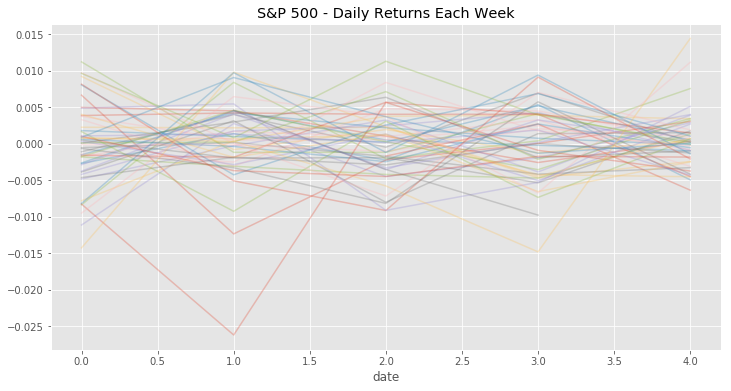

In [12]:
pivoted_d.plot(legend=False, figsize=(12,6), alpha=0.3)
plt.title('S&P 500 - Daily Returns Each Week');

From the plot above it appears that day 1 or Tuesday has the greatest variability. Day 4 or Friday has the largest positive return. Using the describe command on the data we can calculate some basic statistics about each of the days.

In [13]:
by_days = pivoted_d.transpose().describe()
by_days.rename(columns={0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri'}, inplace=True)
by_days

date,Mon,Tue,Wed,Thu,Fri
count,51.000000,52.000000,5.300000e+01,53.000000,52.000000
mean,-0.000199,0.000452,-3.880651e-07,0.000052,0.000456
std,0.005492,0.005707,4.413644e-03,0.004943,0.003743
min,-0.014263,-0.026197,-9.146930e-03,-0.014812,-0.006360
25%,-0.002800,-0.001859,-2.462463e-03,-0.003858,-0.001497
50%,0.000076,0.000597,2.659661e-04,0.000195,0.000226
75%,0.002778,0.004114,2.575893e-03,0.003945,0.001781
max,0.011209,0.009791,1.129563e-02,0.009399,0.014417


**Some observations:**
- Friday does indeed have the highest daily average return at 4.5 bps, but it has the lowest standard deviation at 37 bps.
- Tuesday shares the highest daily average return with Friday, but it also has the largest standard deviation at 57 bps.
- Wednesday is generally pretty flat with a virtual 0 average return.
- Only Monday has a negative daily average return at 2 bps.
<br><br>
How significant is Friday's performance? We can check that by running a simulation which we will do later.